In [1]:
#!/usr/bin/env python
# coding: utf-8

%cd '/Users/juliencatanese/Dropbox/Datascientest/Projet_datascientest/Data_Kaggle'

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Lecture des donnees PTB.csv
ptb_abnormal = pd.read_csv('./ptbdb_abnormal.csv', header=None)
ptb_normal = pd.read_csv('./ptbdb_normal.csv', header=None)

# Concatenation des deux DataFrames
ptb = pd.concat([ptb_normal, ptb_abnormal], ignore_index=True, sort=False)
ptb.rename(columns={187 :'class'}, inplace=True)

# Lecture des donnees MIT.csv
mit_train = pd.read_csv('./mitbih_train.csv', header=None)
mit_test = pd.read_csv('./mitbih_test.csv', header=None)

# Concatenation des deux DataFrames
mit = pd.concat([mit_train, mit_test], ignore_index=True, sort=False)
mit.rename(columns={187 :'class'}, inplace=True)

# Groupement des classes non-normal (1,2,3,4) en une seule classe Anormal (label=1)
mit['class'].replace({2:1,3:1,4:1}, inplace=True)

# Concatenation des jeux de donnees PTB et MIT  
data = pd.concat([ptb, mit], ignore_index=True, sort=False)

y = data['class'].copy()
X = data.drop('class', axis=1).copy()

X_train90, X_valid, y_train90, y_valid = train_test_split(X, y, train_size=0.9, random_state=1,shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X_train90, y_train90, train_size=0.8, random_state=1,shuffle=True)
print('X_train.shape=', X_train.shape)





/Users/juliencatanese/Dropbox/Datascientest/Projet_datascientest/Data_Kaggle
X_train.shape= (89278, 187)


In [2]:
data =X; target=y; 
data.head()

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0.5, 1.0, 'signal original')

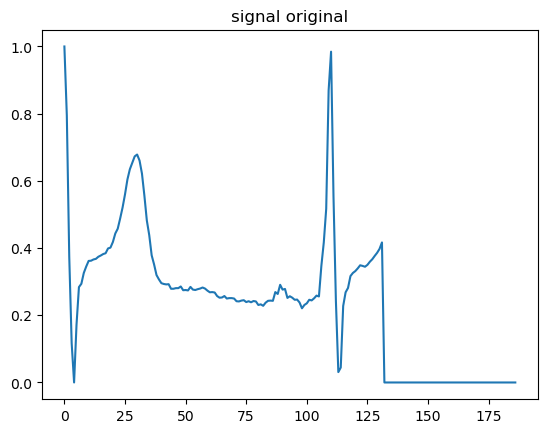

In [57]:
import matplotlib.pyplot as plt
plt.plot(data.iloc[1,:]);
plt.title('signal original')

# DIMENSION REDUCTION

### Using a Manual Windows average (too slow)

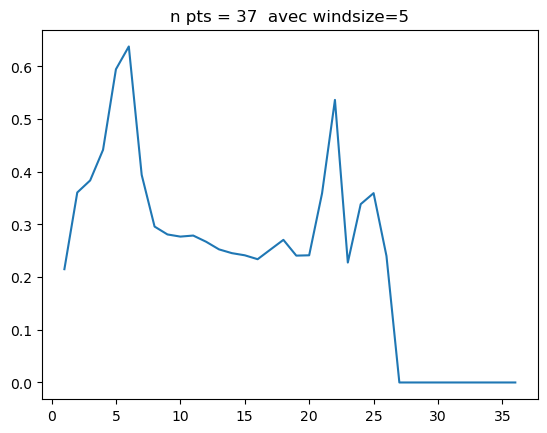

In [59]:
windsize = 5
w=0
data_ligne=[]
for i_col in range(data.shape[1]):
    w+=1
    if w==windsize:
        data_ligne.append(data.iloc[1,i_col-w:i_col].mean())
        w=0
plt.plot(data_ligne);
plt.title( 'n pts = '+ str(len(data_ligne)) + '  avec windsize=' + str(windsize) );

### Using Decimate function from scipy (good)


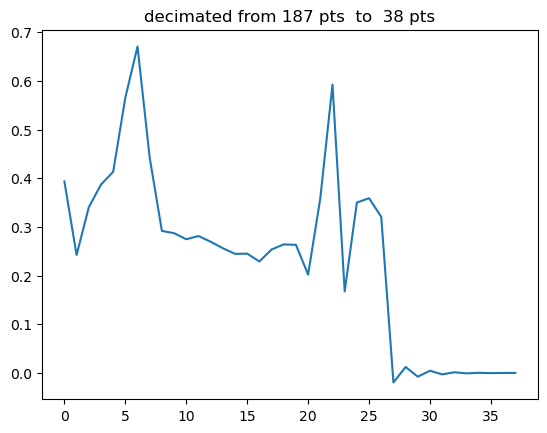

In [69]:
from scipy.signal import decimate
q=5
data_decim = decimate(data, q, n=None, ftype='fir', axis=-1, zero_phase=True)
plt.plot(data_decim[1,:])
data_decim.shape
plt.title('decimated from 187 pts  to  ' + str(data_decim.shape[1]) + ' pts');

In [51]:
data_decim.shape

(123998, 38)

In [52]:
data.shape

(123998, 187)

### PCA:

In [60]:
from sklearn.decomposition import PCA 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [61]:
pca= PCA(0.9)
pca.fit(data)
data_pca = pca.transform(data)
data_pca.shape

(123998, 23)

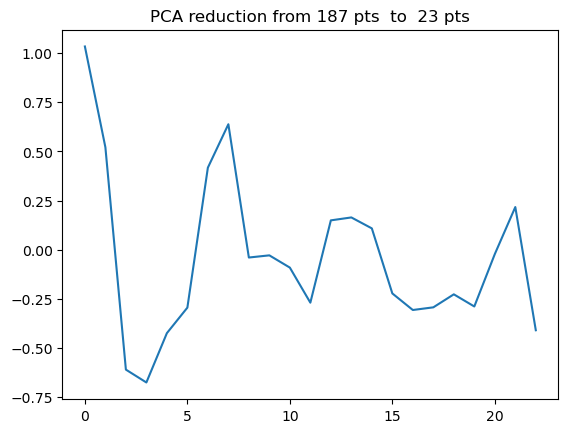

In [95]:
plt.plot(data_pca[1,:])
plt.title('PCA reduction from 187 pts  to  ' + str(data_pca.shape[1]) + ' pts');

### conclusion :  

on a donc reduit les dimensions via 

    - decimate (filter + downsample ) ==> 38 pts pour conserver un signal ressemblant a l"original
    
    - PCA ==> 23 pts pour 90% de la variance

# Training Models with reduced dimension 

## Decision Tree

### Full Data 

In [72]:
from sklearn.tree import DecisionTreeClassifier 
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
print('train score =',model.score(X_train, y_train))
print('test score =',model.score(X_test, y_test))

from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

train score = 1.0
test score = 0.9270609318996416
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95     16935
         1.0       0.86      0.84      0.85      5385

    accuracy                           0.93     22320
   macro avg       0.90      0.90      0.90     22320
weighted avg       0.93      0.93      0.93     22320



### Decimate Data 

In [81]:
y = target
X = data_decim
X_train90, X_valid, y_train90, y_valid = train_test_split(X, y, train_size=0.9, random_state=1,shuffle=True)
X_train_decim, X_test_decim, y_train, y_test = train_test_split(X_train90, y_train90, train_size=0.8, random_state=1,shuffle=True)
print('X_train_decim.shape=', X_train_decim.shape)


X_train_decim.shape= (89278, 38)


In [82]:
model = DecisionTreeClassifier()
model.fit(X_train_decim, y_train)
print('train score =',model.score(X_train_decim, y_train))
print('test score =',model.score(X_test_decim, y_test))

y_pred = model.predict(X_test_decim)
print(classification_report(y_test, y_pred))

train score = 1.0
test score = 0.9184139784946237
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95     16935
         1.0       0.83      0.83      0.83      5385

    accuracy                           0.92     22320
   macro avg       0.89      0.89      0.89     22320
weighted avg       0.92      0.92      0.92     22320



### PCA Data 

In [89]:
y = target
X = data_pca
X_train90, X_valid, y_train90, y_valid = train_test_split(X, y, train_size=0.9, random_state=1,shuffle=True)
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_train90, y_train90, train_size=0.8, random_state=1,shuffle=True)
print('X_train_pca.shape=', X_train_pca.shape)


X_train_pca.shape= (89278, 23)


In [90]:
model = DecisionTreeClassifier()
model.fit(X_train_pca, y_train)
print('train score =',model.score(X_train_pca, y_train))
print('test score =',model.score(X_test_pca, y_test))

y_pred = model.predict(X_test_pca)
print(classification_report(y_test, y_pred))

train score = 1.0
test score = 0.9113351254480286
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94     16935
         1.0       0.82      0.81      0.82      5385

    accuracy                           0.91     22320
   macro avg       0.88      0.88      0.88     22320
weighted avg       0.91      0.91      0.91     22320



## LOGISTIC REGRESSION

## Full Data

In [88]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
print('train score =',model.score(X_train, y_train))
print('test score =',model.score(X_test, y_test))

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

train score = 0.8264746074060799
test score = 0.8237903225806451
              precision    recall  f1-score   support

         0.0       0.83      0.96      0.89     16935
         1.0       0.76      0.39      0.52      5385

    accuracy                           0.82     22320
   macro avg       0.80      0.68      0.71     22320
weighted avg       0.82      0.82      0.80     22320



### Decimate Data : Logistic


In [93]:
model = LogisticRegression()
model.fit(X_train_decim, y_train)
print('train score =',model.score(X_train_decim, y_train))
print('test score =',model.score(X_test_decim, y_test))

y_pred = model.predict(X_test_decim)
print(classification_report(y_test, y_pred))

train score = 0.8378883935572033
test score = 0.837410394265233
              precision    recall  f1-score   support

         0.0       0.84      0.97      0.90     16935
         1.0       0.81      0.42      0.56      5385

    accuracy                           0.84     22320
   macro avg       0.83      0.70      0.73     22320
weighted avg       0.83      0.84      0.82     22320



/Users/juliencatanese/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### PCA Data  : Logistic


In [92]:
model = LogisticRegression()
model.fit(X_train_pca, y_train)
print('train score =',model.score(X_train_pca, y_train))
print('test score =',model.score(X_test_pca, y_test))

y_pred = model.predict(X_test_pca)
print(classification_report(y_test, y_pred))

train score = 0.8264746074060799
test score = 0.8237903225806451
              precision    recall  f1-score   support

         0.0       0.83      0.96      0.89     16935
         1.0       0.76      0.39      0.52      5385

    accuracy                           0.82     22320
   macro avg       0.80      0.68      0.71     22320
weighted avg       0.82      0.82      0.80     22320



In [ ]:
# MON CODE DE DOWNSAMPLING QUI EST BCP TROP LENT
windsize = 4
w=0
newdata=pd.DataFrame([])
for j_ligne in range(data.shape[0]):
#     print(j_ligne)
    data_ligne=[]
    for i_col in range(data.shape[1]):
        w+=1
        if w==windsize:
            data_ligne.append(data.iloc[1,i_col-w:i_col].mean())
            w=0
    newdata = pd.concat((newdata, pd.DataFrame(data_ligne)), axis=1)
              
              
newdata.shape           

In [ ]:
# POUR AJOUTER DES LIGNES A UN DATAFRAME
# pd.concat(objs: 'Iterable[NDFrame] | Mapping[Hashable, NDFrame]', 
#        axis: 'Axis' = 0, 
#        join: 'str' = 'outer', 
#        ignore_index: 'bool' = False, 
#        keys=None, 
#        levels=None, names=None, 
#        verify_integrity: 'bool' = False, 
#        sort: 'bool' = False, 
#        copy: 'bool' = True) 